In [1]:
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt
import seaborn as sns
from sqlalchemy import create_engine
import sys
import os
sys.path.append(os.path.abspath(os.path.join(os.getcwd(), '..')))
from src.outlier_handling import winsorize_column, remove_outliers_zscore, remove_outliers_iqr
from src.data_preprocessing import fill_numeric_missing_values, fill_categorical_missing_values
from src.transformations import log_transform_column, sqrt_transform_column
from src.user_experience_analysis import (
    aggregate_customer_experience,
    get_top_bottom_frequent,
    plot_throughput_distribution,
    plot_tcp_retransmission_per_handset,
    perform_kmeans_clustering)

In [2]:
DATABASE_TYPE = 'postgresql'
DBAPI = 'psycopg2'
HOST = 'localhost'
PORT = '5432'
DATABASE = 'Week2'
USER = 'postgres'
PASSWORD = '183153'

In [3]:
engine = create_engine(f'{DATABASE_TYPE}+{DBAPI}://{USER}:{PASSWORD}@{HOST}:{PORT}/{DATABASE}')

In [4]:
query = "SELECT * FROM xdr_data;"
data = pd.read_sql(query, engine)

In [5]:
data.head()

,Bearer Id,Start,Start ms,End,End ms,Dur. (ms),IMSI,MSISDN/Number,IMEI,Last Location Name,...,Youtube DL (Bytes),Youtube UL (Bytes),Netflix DL (Bytes),Netflix UL (Bytes),Gaming DL (Bytes),Gaming UL (Bytes),Other DL (Bytes),Other UL (Bytes),Total UL (Bytes),Total DL (Bytes)
0,1.311448e+19,4/4/2019 12:01,770.0,4/25/2019 14:35,662.0,1823652.0,2.082014e+14,3.366496e+10,3.552121e+13,9.16456699548519E+015,...,15854611.0,2501332.0,8198936.0,9656251.0,278082303.0,14344150.0,171744450.0,8814393.0,36749741.0,308879636.0
1,1.311448e+19,4/9/2019 13:04,235.0,4/25/2019 8:15,606.0,1365104.0,2.082019e+14,3.368185e+10,3.579401e+13,L77566A,...,20247395.0,19111729.0,18338413.0,17227132.0,608750074.0,1170709.0,526904238.0,15055145.0,53800391.0,653384965.0
2,1.311448e+19,4/9/2019 17:42,1.0,4/25/2019 11:58,652.0,1361762.0,2.082003e+14,3.376063e+10,3.528151e+13,D42335A,...,19725661.0,14699576.0,17587794.0,6163408.0,229584621.0,395630.0,410692588.0,4215763.0,27883638.0,279807335.0
3,1.311448e+19,4/10/2019 0:31,486.0,4/25/2019 7:36,171.0,1321509.0,2.082014e+14,3.375034e+10,3.535661e+13,T21824A,...,21388122.0,15146643.0,13994646.0,1097942.0,799538153.0,10849722.0,749039933.0,12797283.0,43324218.0,846028530.0
4,1.311448e+19,4/12/2019 20:10,565.0,4/25/2019 10:40,954.0,1089009.0,2.082014e+14,3.369980e+10,3.540701e+13,D88865A,...,15259380.0,18962873.0,17124581.0,415218.0,527707248.0,3529801.0,550709500.0,13910322.0,38542814.0,569138589.0


In [6]:
data.isnull().sum()

Bearer Id                                      991
Start                                            1
Start ms                                         1
End                                              1
End ms                                           1
Dur. (ms)                                        1
IMSI                                           570
MSISDN/Number                                 1066
IMEI                                           572
Last Location Name                            1153
Avg RTT DL (ms)                              27829
Avg RTT UL (ms)                              27812
Avg Bearer TP DL (kbps)                          1
Avg Bearer TP UL (kbps)                          1
TCP DL Retrans. Vol (Bytes)                  88146
TCP UL Retrans. Vol (Bytes)                  96649
DL TP < 50 Kbps (%)                            754
50 Kbps < DL TP < 250 Kbps (%)                 754
250 Kbps < DL TP < 1 Mbps (%)                  754
DL TP > 1 Mbps (%)             

In [7]:
high_skew_cols = ['MSISDN/Number', 'IMSI', 'TCP DL Retrans. Vol (Bytes)', 'HTTP DL (Bytes)', 'HTTP UL (Bytes)']
log_transform_cols = ['MSISDN/Number', 'IMSI', 'HTTP DL (Bytes)', 'HTTP UL (Bytes)', 'Total UL (Bytes)', 'Total DL (Bytes)']
sqrt_transform_cols = ['UL TP < 10 Kbps (%)', 'Gaming DL (Bytes)', 'Social Media DL (Bytes)']
zscore_cols = ['TCP DL Retrans. Vol (Bytes)', 'HTTP DL (Bytes)', 'HTTP UL (Bytes)']
iqr_cols = ['UL TP < 10 Kbps (%)', 'Gaming DL (Bytes)', 'Social Media DL (Bytes)']


In [8]:
def process_outliers(data, high_skew_cols, log_transform_cols, sqrt_transform_cols, zscore_cols, iqr_cols):
    for col in high_skew_cols:
        data[col] = winsorize_column(data[col])
    
    for col in log_transform_cols:
        data[col] = log_transform_column(data[col])
    
    for col in sqrt_transform_cols:
        data[col] = sqrt_transform_column(data[col])
    
    for col in zscore_cols:
        data = remove_outliers_zscore(data, col)
    
    for col in iqr_cols:
        data[col] = remove_outliers_iqr(data[col])
    
    return data

In [9]:
processed_data = process_outliers(data, high_skew_cols, log_transform_cols, sqrt_transform_cols, zscore_cols, iqr_cols)

In [10]:
processed_data

,Bearer Id,Start,Start ms,End,End ms,Dur. (ms),IMSI,MSISDN/Number,IMEI,Last Location Name,...,Youtube DL (Bytes),Youtube UL (Bytes),Netflix DL (Bytes),Netflix UL (Bytes),Gaming DL (Bytes),Gaming UL (Bytes),Other DL (Bytes),Other UL (Bytes),Total UL (Bytes),Total DL (Bytes)
0,1.311448e+19,4/4/2019 12:01,770.0,4/25/2019 14:35,662.0,1823652.0,32.969527,24.239723,3.552121e+13,9.16456699548519E+015,...,1.585461e+07,2.501332e+06,8.198936e+06,9.656251e+06,16675.799921,1.434415e+07,1.717444e+08,8.814393e+06,17.419642,19.548462
1,1.311448e+19,4/9/2019 13:04,235.0,4/25/2019 8:15,606.0,1365104.0,32.969529,24.240225,3.579401e+13,L77566A,...,2.024740e+07,1.911173e+07,1.833841e+07,1.722713e+07,24672.861083,1.170709e+06,5.269042e+08,1.505514e+07,17.800791,20.297677
2,1.311448e+19,4/9/2019 17:42,1.0,4/25/2019 11:58,652.0,1361762.0,32.969522,24.242561,3.528151e+13,D42335A,...,1.972566e+07,1.469958e+07,1.758779e+07,6.163408e+06,15152.050059,3.956300e+05,4.106926e+08,4.215763e+06,17.143551,19.449612
3,1.311448e+19,4/10/2019 0:31,486.0,4/25/2019 7:36,171.0,1321509.0,32.969527,24.242256,3.535661e+13,T21824A,...,2.138812e+07,1.514664e+07,1.399465e+07,1.097942e+06,28276.105690,1.084972e+07,7.490399e+08,1.279728e+07,17.584222,20.556064
4,1.311448e+19,4/12/2019 20:10,565.0,4/25/2019 10:40,954.0,1089009.0,32.969527,24.240758,3.540701e+13,D88865A,...,1.525938e+07,1.896287e+07,1.712458e+07,4.152180e+05,22971.879505,3.529801e+06,5.507095e+08,1.391032e+07,17.467280,20.159635
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
149996,7.277826e+18,4/29/2019 7:28,451.0,4/30/2019 6:02,214.0,81230.0,32.969531,24.239299,3.548311e+13,D20434A,...,1.619167e+07,1.176343e+07,1.788370e+07,1.967816e+07,22947.977536,9.197207e+06,3.264510e+06,1.348742e+07,17.869534,20.168445
149997,7.349883e+18,4/29/2019 7:28,483.0,4/30/2019 10:41,187.0,97970.0,32.969529,24.239679,3.566051e+13,D10223C,...,1.387723e+07,8.288284e+06,1.935015e+07,2.129315e+07,25037.832614,4.735033e+06,7.121804e+08,2.457758e+06,17.482530,20.317774
149998,1.311448e+19,4/29/2019 7:28,283.0,4/30/2019 10:46,810.0,98249.0,32.969528,24.238443,3.572121e+13,T51102A,...,2.266051e+07,1.855903e+06,9.963942e+06,5.065760e+06,23527.419833,1.339432e+07,1.211009e+08,1.131473e+07,17.368348,20.200345
149999,1.311448e+19,4/29/2019 7:28,696.0,4/30/2019 10:40,327.0,97910.0,32.969530,24.238376,8.618620e+13,L88342B,...,8.817106e+06,8.305402e+06,3.322253e+06,1.317259e+07,18775.967911,2.529475e+06,8.147131e+08,1.406930e+06,17.204166,19.734125


In [11]:
processed_data.isnull().sum()

Bearer Id                                      986
Start                                            1
Start ms                                         1
End                                              1
End ms                                           1
Dur. (ms)                                        1
IMSI                                           566
MSISDN/Number                                 1055
IMEI                                           568
Last Location Name                            1148
Avg RTT DL (ms)                              27827
Avg RTT UL (ms)                              27810
Avg Bearer TP DL (kbps)                          1
Avg Bearer TP UL (kbps)                          1
TCP DL Retrans. Vol (Bytes)                  88146
TCP UL Retrans. Vol (Bytes)                  96607
DL TP < 50 Kbps (%)                            754
50 Kbps < DL TP < 250 Kbps (%)                 754
250 Kbps < DL TP < 1 Mbps (%)                  754
DL TP > 1 Mbps (%)             

In [12]:
data = fill_categorical_missing_values(processed_data)
data = fill_numeric_missing_values(processed_data)

In [13]:
data.isnull().sum()

Bearer Id                                   0
Start                                       0
Start ms                                    0
End                                         0
End ms                                      0
Dur. (ms)                                   0
IMSI                                        0
MSISDN/Number                               0
IMEI                                        0
Last Location Name                          0
Avg RTT DL (ms)                             0
Avg RTT UL (ms)                             0
Avg Bearer TP DL (kbps)                     0
Avg Bearer TP UL (kbps)                     0
TCP DL Retrans. Vol (Bytes)                 0
TCP UL Retrans. Vol (Bytes)                 0
DL TP < 50 Kbps (%)                         0
50 Kbps < DL TP < 250 Kbps (%)              0
250 Kbps < DL TP < 1 Mbps (%)               0
DL TP > 1 Mbps (%)                          0
UL TP < 10 Kbps (%)                         0
10 Kbps < UL TP < 50 Kbps (%)     

In [14]:
# Aggregate customer experience metrics
agg_data = aggregate_customer_experience(data)

In [15]:
agg_data

,TCP DL Retrans. Vol (Bytes),Avg RTT DL (ms),Handset Type,DL TP < 50 Kbps (%),50 Kbps < DL TP < 250 Kbps (%),250 Kbps < DL TP < 1 Mbps (%),DL TP > 1 Mbps (%)
Bearer Id,,,,,,,
6.917538e+18,1.344110e+05,429.000000,Huawei P8 Lite,100.0,0.0,0.0,0.0
6.917538e+18,4.171991e+06,109.331047,undefined,100.0,0.0,0.0,0.0
6.917538e+18,6.054200e+04,1412.000000,Sony Mobile Comm. Xperia L1,99.0,0.0,0.0,0.0
6.917538e+18,4.667960e+05,738.000000,Sony Mobile Comm. Xperia L1,98.0,1.0,0.0,0.0
6.917538e+18,9.123390e+05,887.000000,Apple iPhone 7 (A1778),95.0,3.0,1.0,0.0
...,...,...,...,...,...,...,...
1.318654e+19,1.712340e+05,55.000000,Huawei B525S-23A,99.0,0.0,0.0,0.0
1.318654e+19,4.171991e+06,45.000000,Huawei P20 Pro,100.0,0.0,0.0,0.0
1.318654e+19,9.270680e+05,46.000000,Huawei B525S-23A,88.0,0.0,0.0,10.0


In [16]:
top_tcp, bottom_tcp, most_frequent_tcp = get_top_bottom_frequent(agg_data, 'TCP DL Retrans. Vol (Bytes)')

In [17]:
top_tcp

Bearer Id
1.304243e+19    74768674.0
1.304243e+19    74713891.0
1.304243e+19    74594958.0
1.311448e+19    74584039.0
6.917538e+18    74567701.0
1.304243e+19    74532740.0
7.277826e+18    74523438.0
7.349883e+18    74519258.0
7.277826e+18    74425846.0
1.304243e+19    74420347.0
Name: TCP DL Retrans. Vol (Bytes), dtype: float64

In [18]:
bottom_tcp

Bearer Id
6.917538e+18    82.0
6.917538e+18    82.0
6.917538e+18    82.0
6.917538e+18    82.0
6.917538e+18    82.0
6.917538e+18    82.0
6.917538e+18    82.0
6.917538e+18    82.0
6.917538e+18    82.0
6.917538e+18    82.0
Name: TCP DL Retrans. Vol (Bytes), dtype: float64

In [19]:
most_frequent_tcp

4171991

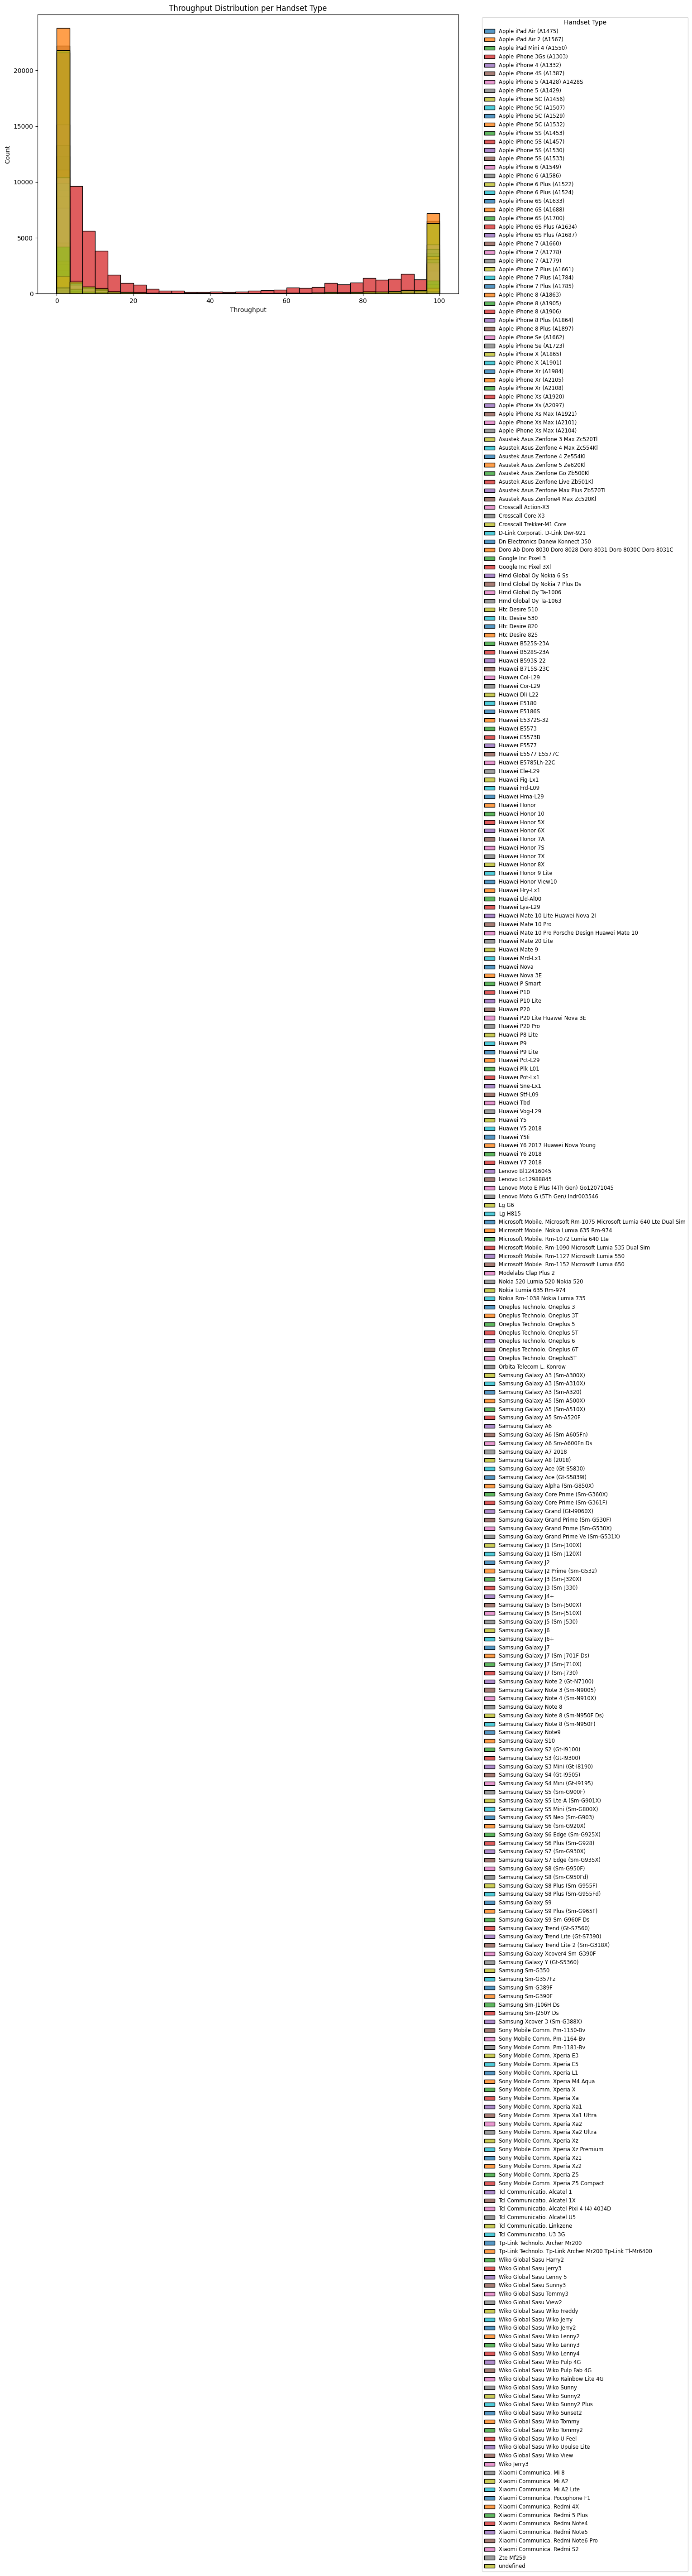

In [20]:
plot_throughput_distribution(agg_data)

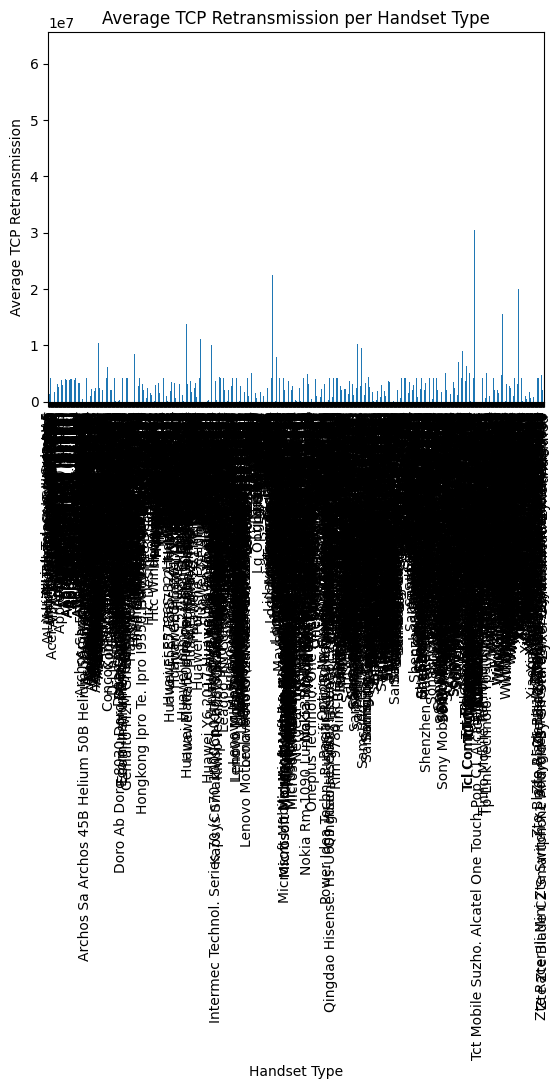

In [21]:
plot_tcp_retransmission_per_handset(agg_data)